In [22]:
import os, pickle
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from math import sin, cos, acos, radians

import tensorflow as tf
import keras
from keras import layers


# Paths

In [6]:
DATA_DIR = "../DataCollection"
DATACOMBINED = os.path.join(DATA_DIR, "data/dataCombined")
POLY_PATH = os.path.join(DATA_DIR, "usaPolygonGrid.pkl")
TRAIN_PATH = os.path.join(DATA_DIR, "trainData.npy")
TEST_PATH = os.path.join(DATA_DIR, "testData.npy")

# Data Inspection



In [7]:
# Load files
trainFiles = np.load(TRAIN_PATH)
testFiles = np.load(TEST_PATH)
usaPolygonGrid = pickle.load(open(POLY_PATH, 'rb'))

In [19]:
print(f"Train samples: {len(trainFiles)}")
print(f"Test samples: {len(testFiles)}")

Train samples: 4420
Test samples: 492


# Defining Model

At its core, the model employs a CNN to extract features and then a LSTM to learn the temporal relationships between the triplet images. A TimeDistributed wrapper is used to apply the CNN to each image in the triplet independently. By default, ResNet is used as the CNN backbone, with the option to build the CNN from scratch. The use of ResNet is strictly for performance reasons, as it is a well-known architecture that has been shown to work well for image classification tasks.

In [13]:
def build_model(useResnet=True, inputShape=(3, 300, 600, 3), gridCount=246):
    if useResnet:
        base = keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=inputShape[1:])
        base.trainable = False
        cnn = keras.Sequential([base, layers.GlobalMaxPooling2D()])
    else:
        cnn = keras.Sequential([
            layers.Conv2D(64, (3,3), padding='same', activation='relu', input_shape=inputShape[1:]),
            layers.MaxPool2D(), layers.BatchNormalization(),
            layers.Conv2D(128, (3,3), padding='same', activation='relu'),
            layers.GlobalMaxPooling2D()
        ])
    model = keras.Sequential([
        layers.TimeDistributed(cnn, input_shape=inputShape),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'), layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dense(gridCount, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.summary()
    return model


# Data Preparation

The numpy arrays from the previous notebook are not in the correct format for training. The following functions below will load the triplet images and prepare them for training. The triplet images are stored in folders named with a grid ID and latitude/longitude coordinates, e.g., "0+lat,lon/". Each folder contains three images.

In [14]:
def read_triplet_data(fileNames, dataDir, gridCount):
    inputShape = (300, 600)
    X, y = [], []
    for name in fileNames:
        folder = os.path.join(dataDir, name)
        imgs = [np.array(tf.keras.utils.load_img(os.path.join(folder, img), target_size=inputShape))
                for img in sorted(os.listdir(folder))]
        X.append(imgs)
        grid = int(name.split('+')[0])
        y.append(grid)
    X = np.array(X)
    y = keras.utils.to_categorical(y, num_classes=gridCount)
    return X, y

# Training

It takes roughly 3 hours to train the model on a MacBook Pro M1. Thus for this model, hyperparameters were kept modest. Additional hyperparameter tuning was done on Google Colab to see if better-performing models could be built.

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ (None, 3, 2048)        │    23,587,712 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │       540,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 246)            │        15,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,161,206 (92.17 MB)

 Trainable params: 573,494 (2.19 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 1050s 943ms/step - categorical_accuracy: 0.0042 - loss: 5.5251
Epoch 2/10
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 1063s 962ms/step - categorical_accuracy: 0.0040 - loss: 5.5083
Epoch 3/10
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 1100s 995ms/step - categorical_accuracy: 0.0063 - loss: 5.5052
Epoch 4/10
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 1151s 1s/step - categorical_accuracy: 0.0040 - loss: 5.5045
Epoch 5/10
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 1080s 978ms/step - categorical_accuracy: 0.0049 - loss: 5.5053
Epoch 6/10
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 1142s 1s/step - categorical_accuracy: 0.0042 - loss: 5.5047
Epoch 7/10
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 1109s 1s/step - categorical_accuracy: 0.0055 - loss: 5.5035
Epoch 8/10
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 1124s 1s/step - categorical_accuracy: 0.0036 - loss: 5.5032
Epoch 9/10
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 1110s 1s/step - categorical_accuracy: 0.0057 - loss: 5.5041
Epoch 10/10
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 1103s 998ms/step - categori

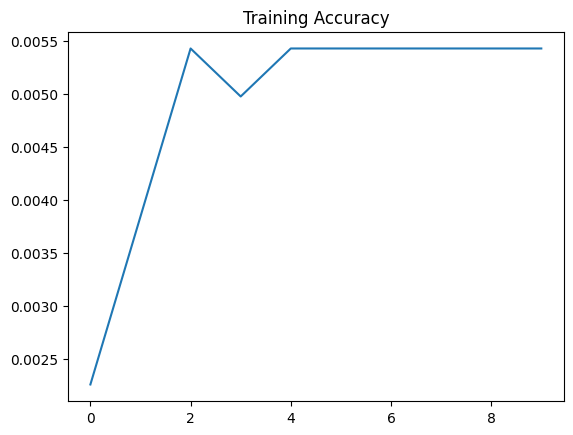

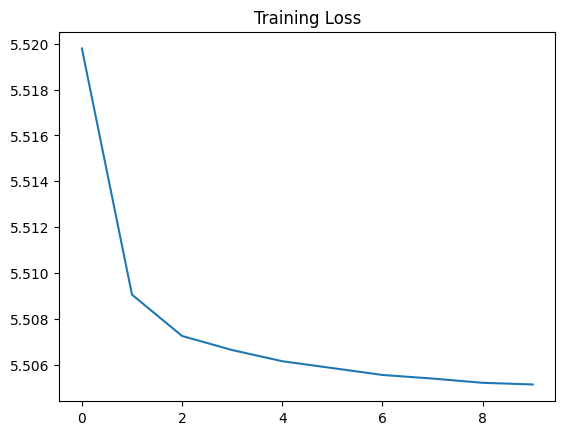

In [17]:
model = build_model(useResnet=True)
X_train, y_train = read_triplet_data(trainFiles, DATACOMBINED, gridCount=246)

history = model.fit(X_train, y_train, epochs=10, batch_size=4)

plt.plot(history.history['categorical_accuracy'])
plt.title("Training Accuracy")
plt.show()

plt.plot(history.history['loss'])
plt.title("Training Loss")
plt.show()

# Evaluation

The model is evaluated using the average distance error between the predicted and true grid centroids. The centroid distance is calculated using the spherical cosine formula, which accounts for the curvature of the Earth. The average distance error is then reported in miles.

In [23]:
def spherical_cosine(lat1, lon1, lat2, lon2):
    R = 3958.8  # Earth's radius in miles
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    return R * acos(sin(lat1)*sin(lat2) + cos(lat1)*cos(lat2)*cos(lon2 - lon1))

def centroid_distance(p1, p2):
    c1, c2 = Polygon(p1).centroid, Polygon(p2).centroid
    return spherical_cosine(c1.y, c1.x, c2.y, c2.x)

def evaluate_model(model, testFiles, polyGrid, dataDir):
    total = 0
    X_test, y_test = read_triplet_data(testFiles, dataDir, gridCount=246)
    preds = model.predict(X_test)
    for i in range(len(preds)):
        true_idx = np.argmax(y_test[i])
        pred_idx = np.argmax(preds[i])
        total += centroid_distance(polyGrid[true_idx], polyGrid[pred_idx])
    return total / len(preds)

avg_dist = evaluate_model(model, testFiles, usaPolygonGrid, DATACOMBINED)
print(f"Average Distance Error: {avg_dist:.2f} miles")


16/16 ━━━━━━━━━━━━━━━━━━━━ 140s 9s/step
Average Distance Error: 1630.69 miles
